In [59]:
import numpy as np
import pandas as pd
import xgboost as xgb
import torch
import math
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import ast
from sklearn.metrics import mean_squared_error
from torch.utils.data import DataLoader, TensorDataset
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from scipy.stats import randint, uniform
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from transformers import BertTokenizer, BertModel
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score


In [60]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [61]:
df_basic = pd.read_csv('/content/drive/MyDrive/research/nlp-hit-song-prediction/merged_dataset.csv')

In [62]:
df_basic.columns

Index(['Unnamed: 0', 'artist_name', 'track_name', 'release_date', 'genre',
       'lyrics', 'len', 'dating', 'violence', 'world/life', 'night/time',
       'shake the audience', 'family/gospel', 'romantic', 'communication',
       'obscene', 'music', 'movement/places', 'light/visual perceptions',
       'family/spiritual', 'like/girls', 'sadness', 'feelings',
       'danceability_x', 'loudness_x', 'acousticness_x', 'instrumentalness_x',
       'valence', 'energy_x', 'topic', 'age', 'song_name', 'song_popularity',
       'song_duration_ms', 'acousticness_y', 'danceability_y', 'energy_y',
       'instrumentalness_y', 'key', 'liveness', 'loudness_y', 'audio_mode',
       'speechiness', 'tempo', 'time_signature', 'audio_valence',
       'lyrics_length'],
      dtype='object')

In [5]:
df_basic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2299 entries, 0 to 2298
Data columns (total 47 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                2299 non-null   int64  
 1   artist_name               2299 non-null   object 
 2   track_name                2299 non-null   object 
 3   release_date              2299 non-null   int64  
 4   genre                     2299 non-null   object 
 5   lyrics                    2299 non-null   object 
 6   len                       2299 non-null   int64  
 7   dating                    2299 non-null   float64
 8   violence                  2299 non-null   float64
 9   world/life                2299 non-null   float64
 10  night/time                2299 non-null   float64
 11  shake the audience        2299 non-null   float64
 12  family/gospel             2299 non-null   float64
 13  romantic                  2299 non-null   float64
 14  communic

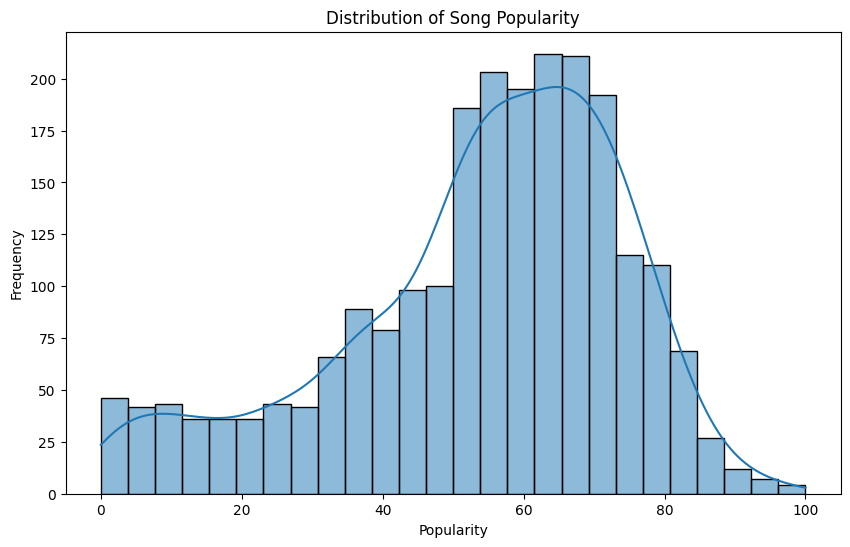

In [6]:
plt.figure(figsize=(10, 6))
sns.histplot(df_basic['song_popularity'], kde=True)
plt.title('Distribution of Song Popularity')
plt.xlabel('Popularity')
plt.ylabel('Frequency')
plt.show()


In [7]:
df_basic.shape

(2299, 47)

In [8]:
df_basic['genre'].unique()

array(['pop', 'country', 'rock', 'hip hop', 'blues', 'reggae', 'jazz'],
      dtype=object)

In [9]:
def plot_correlation_panel(df, attributes1, attributes2):
    num_plots = len(attributes1)
    num_cols = 5
    num_rows = math.ceil(num_plots / num_cols)

    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(25, 5 * num_rows))
    axes = axes.flatten()

    for i, (attr1, attr2) in enumerate(zip(attributes1, attributes2)):
        correlation_coef = df[attr1].corr(df[attr2])
        sns.scatterplot(ax=axes[i], data=df, x=attr1, y=attr2)
        axes[i].set_title(f'Correlation between {attr1} and {attr2}')
        axes[i].set_xlabel(attr1)
        axes[i].set_ylabel(attr2)
        axes[i].text(0.95, 0.95, f"Correlation: $\mathbf{{{correlation_coef:.2f}}}$",
                     transform=axes[i].transAxes, ha="right", va="top")

    for j in range(num_plots, num_rows * num_cols):
        axes[j].set_visible(False)

    plt.tight_layout()
    plt.show()

In [10]:
relevant_features = ['len', 'dating', 'violence', 'world/life', 'night/time',
                    'shake the audience', 'family/gospel', 'romantic', 'communication',
                    'obscene', 'music', 'movement/places', 'light/visual perceptions',
                    'family/spiritual', 'like/girls', 'sadness', 'feelings',
                    'danceability_x', 'loudness_x', 'acousticness_x', 'instrumentalness_x',
                    'valence', 'energy_x', 'age',
                    'song_duration_ms', 'acousticness_y', 'danceability_y', 'energy_y',
                    'instrumentalness_y', 'key', 'liveness', 'loudness_y', 'audio_mode',
                    'speechiness', 'tempo', 'time_signature', 'audio_valence',
                    'lyrics_length', 'song_popularity']

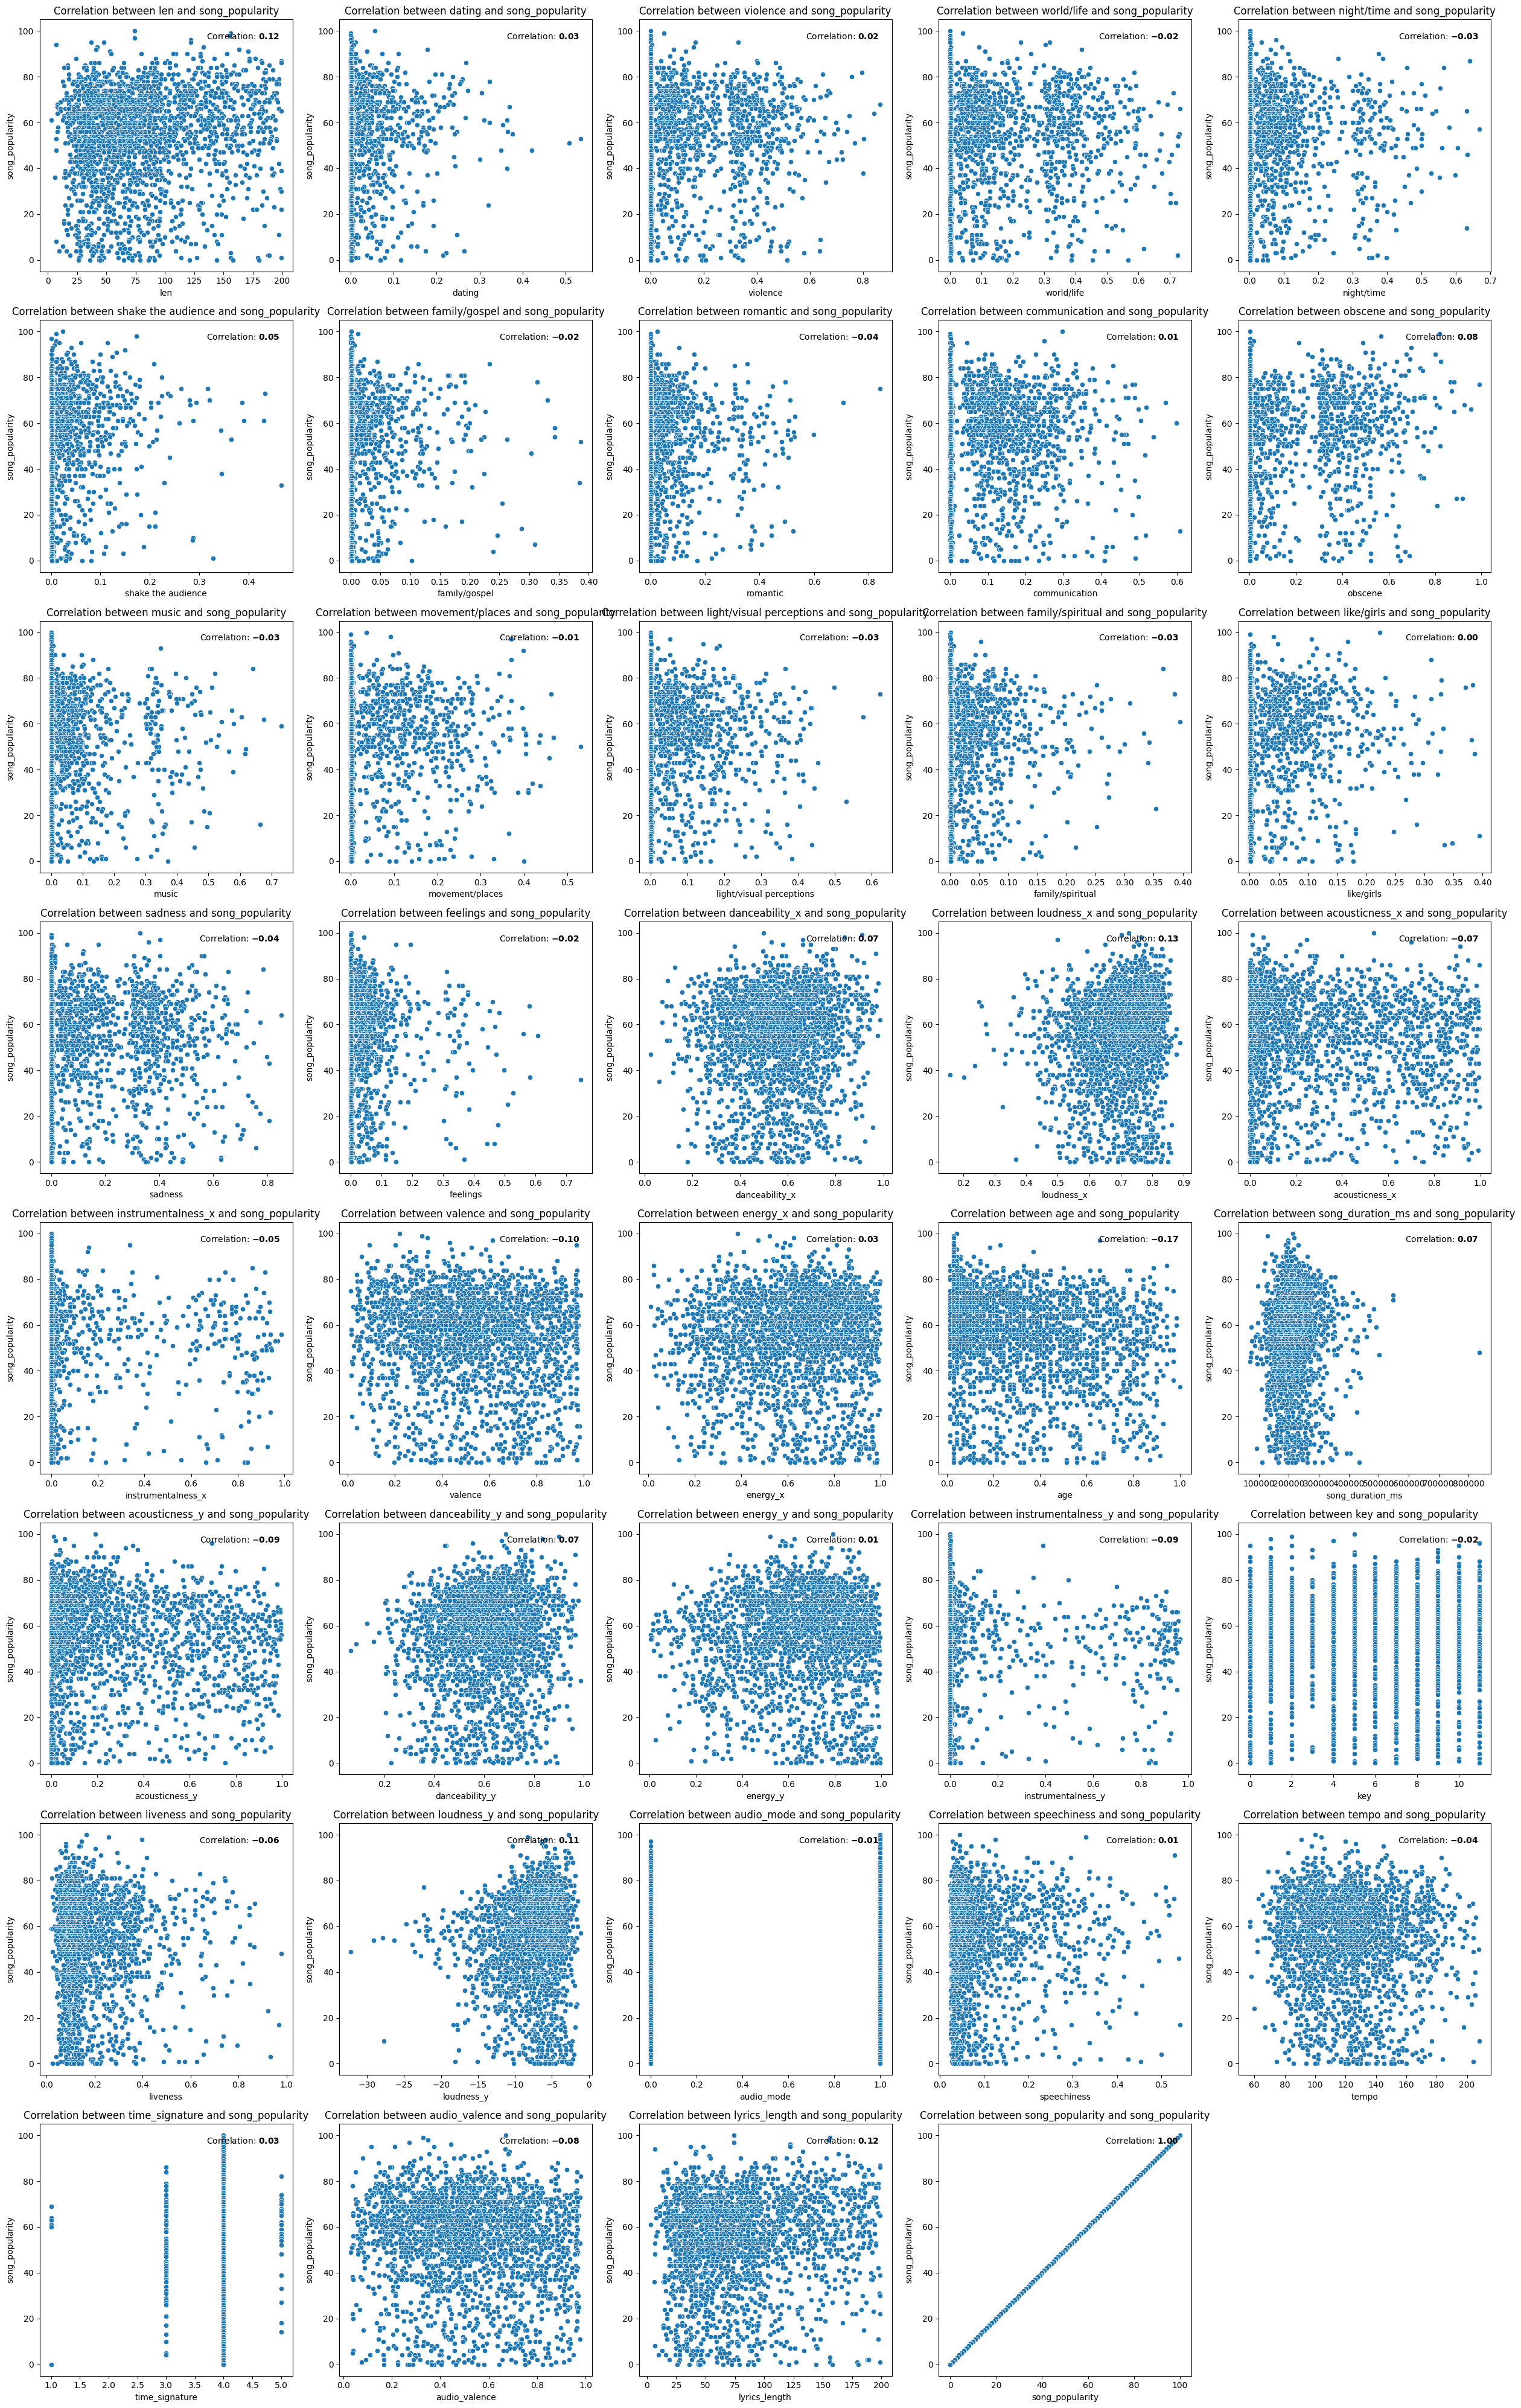

In [11]:
plot_correlation_panel(df_basic, relevant_features, ['song_popularity' for _ in range(0, len(relevant_features))])

In [12]:
def get_bert_embeddings(lyrics_sequences):
  """
  Generates BERT embeddings for a list of lyrics sequences.

  Args:
    lyrics_sequences: A list of strings, where each string is a lyrics sequence.

  Returns:
    A NumPy array of shape (num_sequences, embedding_dim) containing the BERT embeddings.
    Returns None if an error occurs during processing.
  """
  try:
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

    model = BertModel.from_pretrained('bert-base-uncased')
    model.eval()

    embeddings = []
    i = 0
    for sequence in lyrics_sequences:
        inputs = tokenizer(sequence, return_tensors='pt', padding=True, truncation=True)
        i += 1
        if i % 100 == 0:
          print(i)
        with torch.no_grad():
            outputs = model(**inputs)

        # Extract the [CLS] token embedding
        embedding = outputs.last_hidden_state[:, 0, :].numpy()
        embeddings.append(embedding[0])

    return np.array(embeddings)
  except Exception as e:
    print(f"An error occurred: {e}")
    return None


In [150]:
lyrics = df_basic['lyrics'].tolist()
embeddings = get_bert_embeddings(lyrics)

if embeddings is not None:
    print(embeddings)
embeddings.shape


100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
[[-0.07889564  0.00384231  0.44265172 ... -0.17766128 -0.09202536
   0.41525126]
 [ 0.04298168  0.31400147  0.08905667 ... -0.34373802  0.09430842
  -0.0268702 ]
 [-0.01687794 -0.02432959  0.23501946 ... -0.16897134 -0.21422298
   0.04234922]
 ...
 [-0.3948877   0.2836031   0.02444438 ... -0.06745371 -0.13570592
   0.17422345]
 [-0.32806715 -0.1643436   0.37045252 ... -0.29691404 -0.17285587
  -0.04208883]
 [-0.05820426 -0.08035736  0.17658944 ... -0.13017786 -0.11317271
   0.11572261]]


(2299, 768)

In [164]:
df_embedded = df_basic.copy()

In [165]:
df_embedded['embeddings'] = embeddings.tolist()

In [229]:
df_embedded.to_csv('/content/drive/MyDrive/research/nlp-hit-song-prediction/merged_dataset_with_embeddings.csv', index=False)

In [13]:
df_embedded = pd.read_csv('/content/drive/MyDrive/research/nlp-hit-song-prediction/merged_dataset_with_embeddings.csv')

In [15]:
# pca = PCA(n_components=0.95)  # Set n_components to 0.95 to explain 95% of variance
# embeddings_pca = pca.fit_transform(embeddings)

# print(embeddings_pca.shape)
# pca.explained_variance_ratio_


In [16]:
df_embedded.head()

,len,dating,violence,world/life,night/time,shake the audience,family/gospel,romantic,communication,obscene,...,key,liveness,loudness_y,audio_mode,speechiness,tempo,time_signature,audio_valence,lyrics_length,embeddings
0,74,0.055663,0.000849,0.000849,0.000849,0.024309,0.000849,0.025209,0.297448,0.000849,...,5,0.1670,-2.749,1,0.0452,100.015,4,0.671,74,"[-0.07889564335346222, 0.0038423144724220037, ..."
1,156,0.000483,0.050863,0.040735,0.000483,0.009847,0.011901,0.000483,0.000483,0.819429,...,2,0.2590,-8.304,1,0.3300,104.053,4,0.329,156,"[0.04298167675733566, 0.3140014708042145, 0.08..."
2,155,0.000506,0.000506,0.000506,0.000506,0.173152,0.000506,0.000506,0.000506,0.567038,...,1,0.3960,-5.833,1,0.1250,91.030,4,0.350,155,"[-0.01687793619930744, -0.024329591542482376, ..."
3,74,0.000849,0.000849,0.000849,0.000849,0.000849,0.000849,0.000849,0.000849,0.000849,...,4,0.1460,-6.442,0,0.0286,120.013,4,0.273,74,"[-0.15650604665279388, -0.001959748100489378, ..."
4,122,0.000492,0.000492,0.000492,0.077397,0.010698,0.000492,0.000492,0.249879,0.017415,...,11,0.0813,-6.319,1,0.0362,126.684,4,0.443,122,"[-0.112884521484375, 0.05927405133843422, 0.35..."


In [287]:
pcaed_embeddings = pd.DataFrame(embeddings_pca)
pcaed_embeddings.head()

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,-0.171901,1.051347,-1.978899,-0.547801,-0.793134,-0.609557,-0.468883,-0.242355,-0.408701,-0.340288,...,-0.123424,-0.002535,0.078739,0.062235,0.108252,0.034978,-0.174469,-0.039956,-0.009144,-0.032835
1,0.453546,-2.087806,-0.245464,0.050153,-0.881985,1.040584,1.215681,1.132964,0.277176,-1.025104,...,-0.023722,-0.010420,-0.151189,0.005992,0.012775,-0.022882,0.031895,0.020057,0.124105,0.059643
2,0.624580,-2.356864,-0.127152,0.632640,-0.358319,0.818919,0.524440,0.403721,-0.649323,-0.531627,...,0.124047,0.162601,0.059801,-0.092753,0.040485,0.210555,-0.026692,0.067283,0.083634,-0.091537
3,-1.283852,-0.192983,-0.139078,-0.763515,-0.492294,0.450312,-0.244972,0.009051,-0.124574,1.407000,...,0.010049,0.046229,0.036973,-0.102683,0.121831,-0.006265,-0.067112,-0.094485,-0.001826,0.002423
4,-1.128775,-1.116890,-1.390120,-0.276237,-0.757542,0.212799,-0.624330,-0.495100,-0.611046,0.464234,...,-0.133940,-0.103115,0.097844,0.171055,0.039494,-0.047375,-0.001737,-0.096688,0.104796,-0.026376


In [303]:
df_pcaed_embeddings = df_embedded.copy()

In [306]:
df_pcaed_embeddings['embeddings'] = pcaed_embeddings.values.tolist()

In [308]:
df_pcaed_embeddings.to_csv('/content/drive/MyDrive/research/nlp-hit-song-prediction/merged_dataset_with_pcaed_embeddings.csv', index=False)

In [20]:
df_pcaed_embeddings = pd.read_csv('/content/drive/MyDrive/research/nlp-hit-song-prediction/merged_dataset_with_pcaed_embeddings.csv')

In [21]:
df_pcaed_embeddings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2299 entries, 0 to 2298
Data columns (total 48 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                2299 non-null   int64  
 1   artist_name               2299 non-null   object 
 2   track_name                2299 non-null   object 
 3   release_date              2299 non-null   int64  
 4   genre                     2299 non-null   object 
 5   lyrics                    2299 non-null   object 
 6   len                       2299 non-null   int64  
 7   dating                    2299 non-null   float64
 8   violence                  2299 non-null   float64
 9   world/life                2299 non-null   float64
 10  night/time                2299 non-null   float64
 11  shake the audience        2299 non-null   float64
 12  family/gospel             2299 non-null   float64
 13  romantic                  2299 non-null   float64
 14  communic

In [17]:
df_embedded['embeddings'] = df_embedded['embeddings'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

In [18]:
len(df_embedded['embeddings'][0])

768

In [19]:
relevant_features = [feat for feat in df_embedded.columns if feat not in ['release_date', 'Unnamed: 0', 'genre', 'lyrics',
                                                                          'artist_name', 'track_name', 'topic', 'song_name']]

In [20]:
relevant_features

['len',
 'dating',
 'violence',
 'world/life',
 'night/time',
 'shake the audience',
 'family/gospel',
 'romantic',
 'communication',
 'obscene',
 'music',
 'movement/places',
 'light/visual perceptions',
 'family/spiritual',
 'like/girls',
 'sadness',
 'feelings',
 'danceability_x',
 'loudness_x',
 'acousticness_x',
 'instrumentalness_x',
 'valence',
 'energy_x',
 'age',
 'song_popularity',
 'song_duration_ms',
 'acousticness_y',
 'danceability_y',
 'energy_y',
 'instrumentalness_y',
 'key',
 'liveness',
 'loudness_y',
 'audio_mode',
 'speechiness',
 'tempo',
 'time_signature',
 'audio_valence',
 'lyrics_length',
 'embeddings']

In [22]:
# df_pcaed_embeddings = df_pcaed_embeddings[relevant_features]

In [63]:
df_embedded = df_embedded[relevant_features]

In [191]:
# df_old =  pd.read_csv('/content/drive/MyDrive/research/nlp-hit-song-prediction/merged_dataset.csv')

In [85]:
# df.to_csv('/content/drive/MyDrive/research/nlp-hit-song-prediction/merged_dataset_with_pcaed_embeddings.csv', index=False)

In [192]:
# df['popularity'] = df_old['song_popularity']

In [312]:
# df.head()

In [105]:
# df = pd.read_csv('/content/drive/MyDrive/research/nlp-hit-song-prediction/merged_dataset_with_pcaed_embeddings.csv')

In [84]:
# df_old.head()['song_popularity']

,song_popularity
0,100
1,99
2,98
3,97
4,96


In [64]:
class MLP1(nn.Module):
    def __init__(self, total_input_size, hidden_size, output_size):
        super(MLP1, self).__init__()
        self.fc1 = nn.Linear(total_input_size, hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)  # Regularization
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

class MLP2(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP2, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size//2)  # Deeper
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.fc3 = nn.Linear(hidden_size//2, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

In [65]:
def preprocess_and_split_data(df, embeddings_column='embeddings', target_column='song_popularity', test_size=0.2, random_state=42):
    """
    Preprocesses the data and splits it into training and testing sets without data leakage.

    Args:
        df: Input DataFrame.
        embeddings_column: Name of the column containing embeddings.
        target_column: Name of the target column.
        test_size: Proportion of the dataset to include in the test split.
        random_state: Controls shuffling before the split.

    Returns:
        X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor: Split data as tensors.
    """
    # Split data first to avoid leakage
    X = df.drop(target_column, axis=1)
    y = df[target_column]

    # Split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )

    # Process embeddings
    for df_split in [X_train, X_test]:
        df_split[embeddings_column] = df_split[embeddings_column].apply(
            lambda x: ast.literal_eval(x) if isinstance(x, str) else x
        )

    embeddings_train = np.array(X_train[embeddings_column].tolist()).reshape(len(X_train), -1)
    embeddings_test = np.array(X_test[embeddings_column].tolist()).reshape(len(X_test), -1)

    # Process other features
    X_train_other = X_train.drop(embeddings_column, axis=1)
    X_test_other = X_test.drop(embeddings_column, axis=1)

    # Convert to numeric and handle NaNs
    for col in X_train_other.columns:
        X_train_other[col] = pd.to_numeric(X_train_other[col], errors='coerce')
        X_test_other[col] = pd.to_numeric(X_test_other[col], errors='coerce')

    # Impute missing values using training data statistics
    imputer = SimpleImputer(strategy='mean')
    X_train_other_imputed = imputer.fit_transform(X_train_other)
    X_test_other_imputed = imputer.transform(X_test_other)

    # Scale features using training data statistics
    scaler = StandardScaler()
    X_train_other_scaled = scaler.fit_transform(X_train_other_imputed)
    X_test_other_scaled = scaler.transform(X_test_other_imputed)

    # Combine features
    X_train_scaled = np.concatenate((X_train_other_scaled, embeddings_train), axis=1)
    X_test_scaled = np.concatenate((X_test_other_scaled, embeddings_test), axis=1)

    # Convert to tensors
    X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).reshape(-1)
    X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).reshape(-1)

    return X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor

In [66]:
def preprocess_and_split_data_no_embeddings(df, target_column='song_popularity', test_size=0.2, random_state=42):
    """
    Preprocesses data (without embeddings) and splits into training/testing sets,
    avoiding data leakage and handling missing values.

    Args:
        df: Input DataFrame
        target_column: Name of target column
        test_size: Proportion for test split
        random_state: Random seed for reproducibility

    Returns:
        X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor
    """
    # Split first to prevent leakage
    X = df.drop([target_column, 'embeddings'], axis=1, errors='ignore')  # Safer column drop
    y = df[target_column]

    # Initial split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )

    # Convert to numeric and handle NaNs
    for col in X_train.columns:
        X_train[col] = pd.to_numeric(X_train[col], errors='coerce')
        X_test[col] = pd.to_numeric(X_test[col], errors='coerce')

    # Impute missing values using training stats
    imputer = SimpleImputer(strategy='mean')
    X_train_imputed = imputer.fit_transform(X_train)
    X_test_imputed = imputer.transform(X_test)

    # Scale using training data statistics
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_imputed)
    X_test_scaled = scaler.transform(X_test_imputed)

    # Convert to tensors
    X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).reshape(-1)  # 1D tensor
    X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).reshape(-1)

    return X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor

In [67]:
def evaluate_and_plot(model, X_test_tensor, y_test_tensor, train_losses, test_losses):
    """
    Evaluates the model on the test set, plots the training and testing losses,
    and prints the RMSE and R-squared.

    Args:
        model: The trained PyTorch model.
        X_test_tensor: The test data tensor.
        y_test_tensor: The test target tensor.
        train_losses: A list of training losses.
        test_losses: A list of testing losses.
    """

    # Plot training and testing losses
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Testing Loss')
    plt.legend()
    plt.show()

    # Evaluate the model
    with torch.no_grad():
        test_predictions = model(X_test_tensor)

    rmse = np.sqrt(mean_squared_error(y_test_tensor, test_predictions))
    print(f'RMSE: {rmse}')

    mae = mean_squared_error(y_test_tensor, test_predictions)
    print(f'MAE: {mae}')

    r2 = r2_score(y_test_tensor, test_predictions)
    print(f'R-squared: {r2}')



In [68]:
X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor = preprocess_and_split_data(df_embedded)

In [69]:
X_train_tensor.shape

torch.Size([1839, 806])

In [70]:
if len(y_train_tensor.shape) == 1:
    y_train_tensor = y_train_tensor.reshape(-1, 1)
if len(y_test_tensor.shape) == 1:
    y_test_tensor = y_test_tensor.reshape(-1, 1)

In [71]:
input_size = X_train_tensor.shape[1]
hidden_size = 64
output_size = 1
lr = 0.001
criterion = nn.MSELoss()
epochs = 500

model_bert = MLP2(input_size, hidden_size, output_size)
optimizer = optim.Adam(model_bert.parameters(), lr=lr, weight_decay=0.001)

train_losses = []
test_losses = []

In [72]:
for epoch in range(epochs):
    # Training
    model_bert.train()  # Set model to training mode
    optimizer.zero_grad()

    # Forward pass - single input
    train_outputs = model_bert(X_train_tensor)
    train_loss = criterion(train_outputs, y_train_tensor)

    # Backward pass
    train_loss.backward()
    optimizer.step()

    # Evaluation
    model_bert.eval()  # Set model to evaluation mode
    with torch.no_grad():
        # Forward pass - single input for test
        test_outputs = model_bert(X_test_tensor)  # No input splitting!
        test_loss = criterion(test_outputs, y_test_tensor)

    # Store losses
    train_losses.append(train_loss.item())
    test_losses.append(test_loss.item())

    print(f'Epoch [{epoch+1}/{epochs}] | Train Loss: {train_loss.item():.4f} | Test Loss: {test_loss.item():.4f}')

Epoch [1/500] | Train Loss: 3350.4138 | Test Loss: 3283.4189
Epoch [2/500] | Train Loss: 3333.6987 | Test Loss: 3268.5879
Epoch [3/500] | Train Loss: 3318.3616 | Test Loss: 3253.5159
Epoch [4/500] | Train Loss: 3303.1062 | Test Loss: 3236.3591
Epoch [5/500] | Train Loss: 3286.5173 | Test Loss: 3216.3418
Epoch [6/500] | Train Loss: 3266.5686 | Test Loss: 3193.4150
Epoch [7/500] | Train Loss: 3245.1360 | Test Loss: 3167.8447
Epoch [8/500] | Train Loss: 3219.2056 | Test Loss: 3139.7786
Epoch [9/500] | Train Loss: 3191.3110 | Test Loss: 3109.2288
Epoch [10/500] | Train Loss: 3160.7090 | Test Loss: 3076.1577
Epoch [11/500] | Train Loss: 3130.7534 | Test Loss: 3040.4204
Epoch [12/500] | Train Loss: 3091.5525 | Test Loss: 3001.8743
Epoch [13/500] | Train Loss: 3051.0649 | Test Loss: 2960.5144
Epoch [14/500] | Train Loss: 3011.8979 | Test Loss: 2916.1816
Epoch [15/500] | Train Loss: 2965.7627 | Test Loss: 2868.6704
Epoch [16/500] | Train Loss: 2919.0898 | Test Loss: 2817.9309
Epoch [17/500] | 

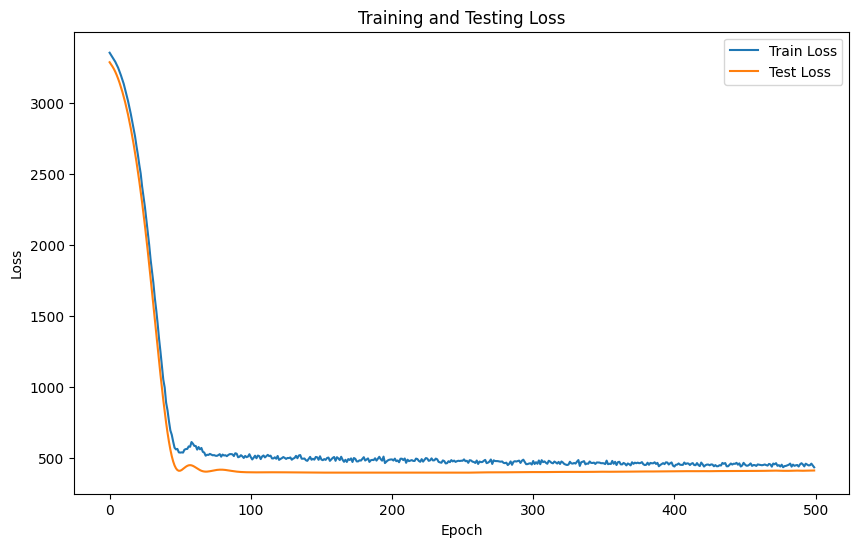

RMSE: 20.259759360035254
MAE: 410.45784932653606
R-squared: 0.008522237343763561


In [73]:
evaluate_and_plot(model_bert, X_test_tensor, y_test_tensor, train_losses, test_losses)

## Let's try excluding the embeddings

In [75]:
X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor = preprocess_and_split_data_no_embeddings(df_embedded)

In [76]:
input_size = X_train_tensor.shape[1]
hidden_size = 64
output_size = 1
lr = 0.001

model_basic = MLP1(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model_basic.parameters(), lr=lr, weight_decay=0.001)

train_losses = []
test_losses = []

epochs = 800

torch.backends.cudnn.enabled = False
torch.manual_seed(42)

In [77]:
if len(y_train_tensor.shape) == 1:
    y_train_tensor = y_train_tensor.reshape(-1, 1)
if len(y_test_tensor.shape) == 1:
    y_test_tensor = y_test_tensor.reshape(-1, 1)

In [80]:
for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = model_basic(X_train_tensor)
    train_loss = criterion(outputs, y_train_tensor)
    train_loss.backward()
    optimizer.step()

    with torch.no_grad():
        test_outputs = model_basic(X_test_tensor)
        test_loss = criterion(test_outputs, y_test_tensor)

    train_losses.append(train_loss.item())
    test_losses.append(test_loss.item())
    print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss.item():.4f}, Test Loss: {test_loss.item():.4f}')



Epoch [1/800], Train Loss: 517.5104, Test Loss: 578.0419
Epoch [2/800], Train Loss: 530.6528, Test Loss: 562.5120
Epoch [3/800], Train Loss: 526.7117, Test Loss: 566.7856
Epoch [4/800], Train Loss: 524.4133, Test Loss: 602.1360
Epoch [5/800], Train Loss: 518.1349, Test Loss: 632.2958
Epoch [6/800], Train Loss: 524.1309, Test Loss: 552.8928
Epoch [7/800], Train Loss: 518.7328, Test Loss: 560.0984
Epoch [8/800], Train Loss: 533.8560, Test Loss: 554.5565
Epoch [9/800], Train Loss: 520.1622, Test Loss: 617.3215
Epoch [10/800], Train Loss: 532.5161, Test Loss: 620.4803
Epoch [11/800], Train Loss: 517.8784, Test Loss: 557.1050
Epoch [12/800], Train Loss: 514.2565, Test Loss: 575.2568
Epoch [13/800], Train Loss: 518.8822, Test Loss: 600.3262
Epoch [14/800], Train Loss: 511.3773, Test Loss: 576.7898
Epoch [15/800], Train Loss: 528.1125, Test Loss: 599.0191
Epoch [16/800], Train Loss: 516.4589, Test Loss: 574.8096
Epoch [17/800], Train Loss: 531.3408, Test Loss: 597.5479
Epoch [18/800], Train L

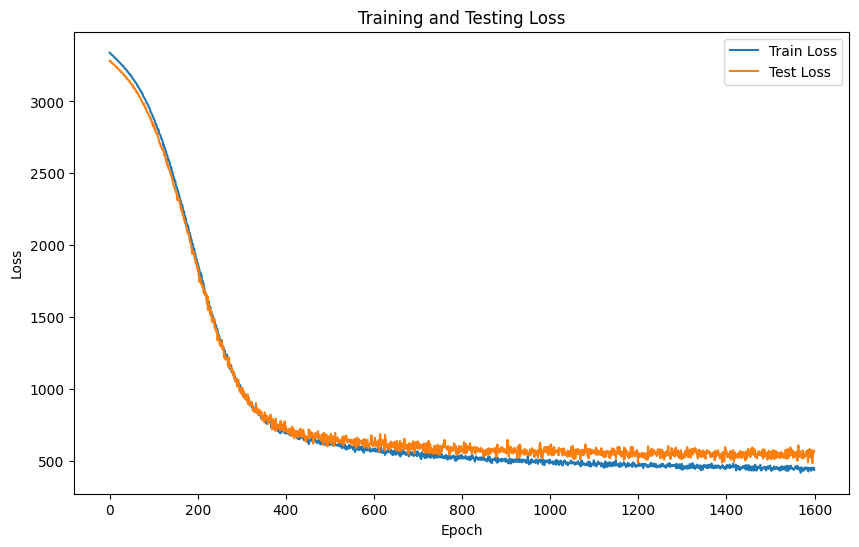

RMSE: 23.45134462088591
MAE: 549.9655645275544
R-squared: -0.3284643681450521


In [81]:
evaluate_and_plot(model_basic, X_test_tensor, y_test_tensor, train_losses, test_losses)

In [82]:
def get_tfidf_embeddings(lyrics_sequences):
    """
    Generates TF-IDF embeddings for a list of lyrics sequences.

    Args:
        lyrics_sequences: A list of strings, where each string is a lyrics sequence.

    Returns:
        A NumPy array of TF-IDF embeddings.
    """
    vectorizer = TfidfVectorizer()
    embeddings = vectorizer.fit_transform(lyrics_sequences)
    return embeddings.toarray()


In [83]:
lyrics = df_basic['lyrics'].tolist()
tfidf_embeddings = get_tfidf_embeddings(lyrics)


pca = PCA(n_components=0.95)
tfidf_embeddings_pca = pca.fit_transform(tfidf_embeddings)

In [84]:
tfidf_embeddings.shape

(2299, 12617)

In [85]:
tfidf_embeddings_pca.shape

(2299, 1497)

In [86]:
df_tf_idfed = df_basic.copy()
df_tf_idfed['embeddings'] = tfidf_embeddings.tolist()

In [48]:
df_tf_idfed.to_csv('/content/drive/MyDrive/research/nlp-hit-song-prediction/merged_dataset_with_tfidf_embeddings_pca.csv', index=False)


In [87]:
df_tf_idfed = df_tf_idfed[relevant_features]

In [88]:
df_tf_idfed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2299 entries, 0 to 2298
Data columns (total 40 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   len                       2299 non-null   int64  
 1   dating                    2299 non-null   float64
 2   violence                  2299 non-null   float64
 3   world/life                2299 non-null   float64
 4   night/time                2299 non-null   float64
 5   shake the audience        2299 non-null   float64
 6   family/gospel             2299 non-null   float64
 7   romantic                  2299 non-null   float64
 8   communication             2299 non-null   float64
 9   obscene                   2299 non-null   float64
 10  music                     2299 non-null   float64
 11  movement/places           2299 non-null   float64
 12  light/visual perceptions  2299 non-null   float64
 13  family/spiritual          2299 non-null   float64
 14  like/gir

In [89]:
X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor = preprocess_and_split_data(df_tf_idfed)

In [90]:
X_train_tensor.shape

torch.Size([1839, 12655])

In [91]:
print(f"Training target shape: {y_train_tensor.shape}")
print(f"Test target shape: {y_test_tensor.shape}")

Training target shape: torch.Size([1839])
Test target shape: torch.Size([460])


In [92]:
if len(y_train_tensor.shape) == 1:
    y_train_tensor = y_train_tensor.reshape(-1, 1)
if len(y_test_tensor.shape) == 1:
    y_test_tensor = y_test_tensor.reshape(-1, 1)

In [93]:
input_size = X_train_tensor.shape[1]
hidden_size = 64
output_size = 1
lr = 0.001
criterion = nn.MSELoss()
epochs = 700


model_tfidf = MLP1(input_size, hidden_size, output_size)
optimizer = optim.Adam(model_tfidf.parameters(), lr=lr, weight_decay=0.001)  # Fixed model reference


train_losses = []
test_losses = []

In [94]:
for epoch in range(epochs):
    model_tfidf.train()

    optimizer.zero_grad()
    outputs = model_tfidf(X_train_tensor)

    train_loss = criterion(outputs, y_train_tensor)
    train_loss.backward()
    optimizer.step()

    # Set model to evaluation mode
    model_tfidf.eval()
    with torch.no_grad():
        test_outputs = model_tfidf(X_test_tensor)
        test_loss = criterion(test_outputs, y_test_tensor)

    train_losses.append(train_loss.item())
    test_losses.append(test_loss.item())
    print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss.item():.4f}, Test Loss: {test_loss.item():.4f}')


Epoch [1/700], Train Loss: 3322.7920, Test Loss: 3269.0500
Epoch [2/700], Train Loss: 3320.5488, Test Loss: 3266.9519
Epoch [3/700], Train Loss: 3318.3640, Test Loss: 3264.9373
Epoch [4/700], Train Loss: 3316.3223, Test Loss: 3262.9993
Epoch [5/700], Train Loss: 3314.3599, Test Loss: 3261.1057
Epoch [6/700], Train Loss: 3312.4817, Test Loss: 3259.2229
Epoch [7/700], Train Loss: 3310.4900, Test Loss: 3257.3096
Epoch [8/700], Train Loss: 3308.5090, Test Loss: 3255.3440
Epoch [9/700], Train Loss: 3306.4221, Test Loss: 3253.3201
Epoch [10/700], Train Loss: 3304.6108, Test Loss: 3251.2324
Epoch [11/700], Train Loss: 3302.3440, Test Loss: 3249.0796
Epoch [12/700], Train Loss: 3299.9910, Test Loss: 3246.8611
Epoch [13/700], Train Loss: 3297.6541, Test Loss: 3244.5740
Epoch [14/700], Train Loss: 3295.4255, Test Loss: 3242.2192
Epoch [15/700], Train Loss: 3292.6321, Test Loss: 3239.7957
Epoch [16/700], Train Loss: 3290.3206, Test Loss: 3237.3003
Epoch [17/700], Train Loss: 3288.3489, Test Loss:

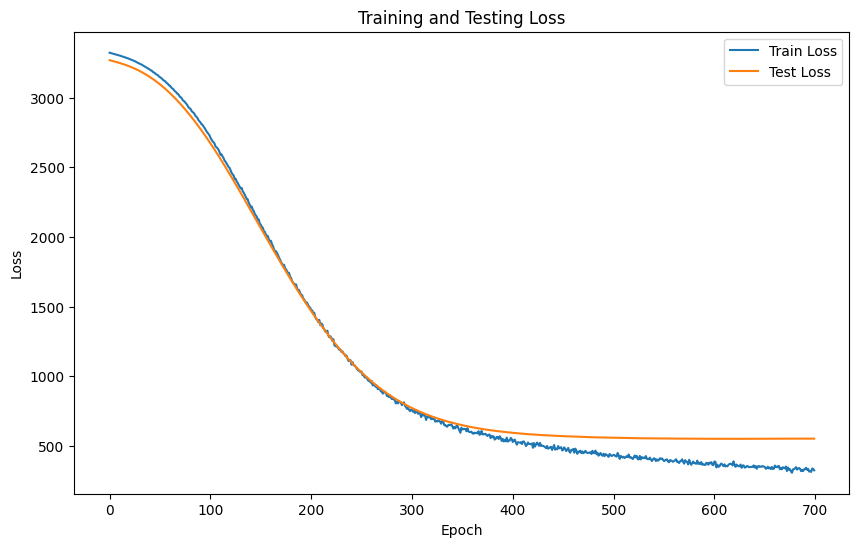

RMSE: 23.512530236226347
MAE: 552.8390781094581
R-squared: -0.33540545800804966


In [95]:
evaluate_and_plot(model_tfidf, X_test_tensor, y_test_tensor, train_losses, test_losses)


In [96]:
class LinearRegressionModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        return self.linear(x)

In [97]:
train_losses = []
test_losses = []

In [102]:
input_dim = X_train_tensor.shape[1]
output_dim = 1
model = LinearRegressionModel(input_dim, output_dim)


criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

train_losses = []
test_losses = []



epochs = 2500
for epoch in range(epochs):
    # Training
    model.train()
    y_pred_train = model(X_train_tensor)
    train_loss = criterion(y_pred_train, y_train_tensor)

    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()

    train_losses.append(train_loss.item())

    # Testing
    model.eval()
    with torch.no_grad():
        y_pred_test = model(X_test_tensor)
        test_loss = criterion(y_pred_test, y_test_tensor)
        test_losses.append(test_loss.item())

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{epochs}], Train Loss: {train_loss.item():.4f}, Test Loss: {test_loss.item():.4f}')



Epoch [10/2500], Train Loss: 3273.1414, Test Loss: 3215.5337
Epoch [20/2500], Train Loss: 3207.4321, Test Loss: 3152.3369
Epoch [30/2500], Train Loss: 3144.1875, Test Loss: 3092.9697
Epoch [40/2500], Train Loss: 3083.0483, Test Loss: 3036.2456
Epoch [50/2500], Train Loss: 3023.7200, Test Loss: 2981.7231
Epoch [60/2500], Train Loss: 2965.9780, Test Loss: 2929.1218
Epoch [70/2500], Train Loss: 2909.6465, Test Loss: 2878.0356
Epoch [80/2500], Train Loss: 2854.5889, Test Loss: 2828.1270
Epoch [90/2500], Train Loss: 2800.7012, Test Loss: 2779.1987
Epoch [100/2500], Train Loss: 2747.9067, Test Loss: 2731.1470
Epoch [110/2500], Train Loss: 2696.1477, Test Loss: 2683.9519
Epoch [120/2500], Train Loss: 2645.3809, Test Loss: 2637.6235
Epoch [130/2500], Train Loss: 2595.5723, Test Loss: 2592.1816
Epoch [140/2500], Train Loss: 2546.6934, Test Loss: 2547.6318
Epoch [150/2500], Train Loss: 2498.7205, Test Loss: 2503.9600
Epoch [160/2500], Train Loss: 2451.6338, Test Loss: 2461.1458
Epoch [170/2500],

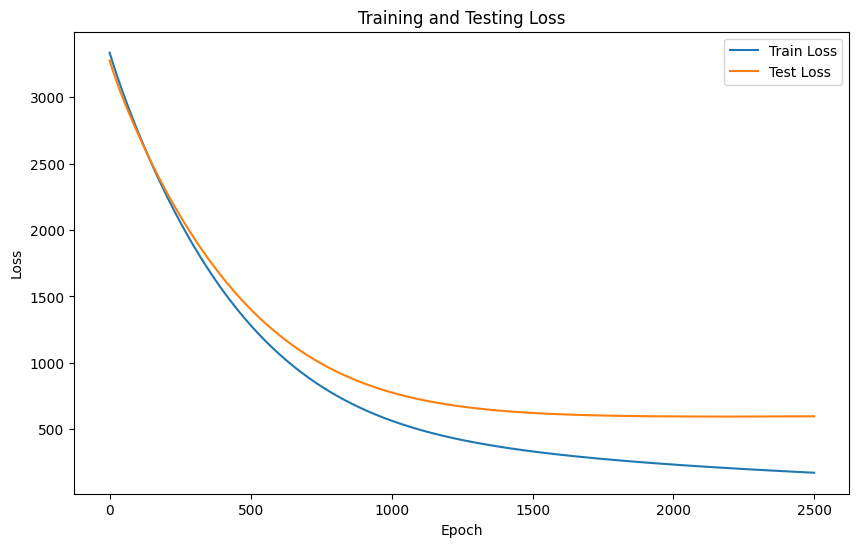

RMSE: 24.455440799207818
MAE: 598.0685846835582
R-squared: -0.4446591854193118


In [103]:
evaluate_and_plot(model, X_test_tensor, y_test_tensor, train_losses, test_losses)